# Average grain size distribution 

- I am using the dataframe created in the previous file to calculate the average HH corr
- Since I have different scansizes and pixel numbers (and therefore, different stepsize), I take the smallest stepsize and I create the interpolated HH corr function over this new scale.
- Once I have the interpolated functions, I can easily average them.

In [14]:
import os
import sys
import json

import numpy as np
import pandas as pd
import pickle
import math

%matplotlib nbagg
%reload_ext autoreload
%autoreload 2
import matplotlib
import matplotlib.lines as mlines
import matplotlib.pyplot as plt


from matplotlib import cm
from skimage import data, img_as_float

from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter
from scipy.stats import sem

In [33]:
debug = False 

path = "/Users/sfiligoj/Desktop/Thesis/Data Analysis/SEM/SEM_all_contrasted_corrected"
os.chdir(path)
# Load the dictionary back from the pickle file.
df = pickle.load( open( "save.p", "rb" ) )

if debug: print(f'select specific density')
if debug: dfTRY = df[df.density=='H']
df.head()

,filename,density,temp,hhcorr,scansize,n_pix
0,H_asdep_006.tif,H,25,"[0.029532958133807113, 0.03172089640968673, 0....",345,1024
1,Ru_LH_500C_015.tif,LH,500,"[0.01841470656196632, 0.02307507579548702, 0.0...",829,1024
2,Ru_LH_700C_077.tif,LH,700,"[0.005772947324770799, 0.006301168366615295, 0...",414,1024
3,L_asdep_007.tif,L,25,"[0.04142936148330632, 0.04775319104077777, 0.0...",11800,1024
4,H_700C_024.tif,H,700,"[0.02107438041374748, 0.02270302762767064, 0.0...",518,1024


# Exclude scansizes:

In [34]:
scansizes_to_drop = [
                     276,
                     345,
                     414,
#                      518,
#                      638,
#                      829,
#                      1180,
#                      1660,
                     2070,
                     2760,
                     3450,
                     4140,4830,5180,6380,8290,
                     11800,
                     16600,
                     20700,82900
                    ]

for s in scansizes_to_drop:
    df.drop(df[df.scansize==s].index, inplace=True)
if debug: dfTRY
    
# write interval you have chosen, so that later output values and images are differenentiated:
interval = '518to1660nm'

# Exclude files:

In [35]:
#Low density:
df.drop(index=77, inplace= True) #: file060 Low density 700C
df.drop(index=93, inplace= True) #: file052 Low density 700C

# Low-High density:
df.drop(index=100, inplace= True) #: file006 Low-High density 250C

df.drop(index=46, inplace= True) #: file073 Low-High density 700C
df.drop(index=121, inplace= True) #: file082 Low-High density 700C
df.drop(index=8, inplace= True) #: file076 Low-High density 700C

df.drop(index=18, inplace= True) #: file029 Low-High density 800C

# Calculation of interpolated HHcorr's on new x-axis range:

- I define x_new as a new range - universally the same for all images with different pixelsize/scansize;
- It is defined as the range with the minimum pixelsize and minimum scansize. As I want to consider only the scansizes similar to my $1x1 um^2$ AFM images I take min_scansize = 1180 (nm),
- Since x_new was different for L, LH and H I had to crate a loop through the densities.

On this new range I can plot HHcorr

In [36]:
densities = ['L','H','LH']
df['hhcorr_interp'] = 'default value'
# I define a the pixel size, which is different for images with different scansizes:
df['px_size'] = df.scansize / df.n_pix

x_new={}
for d in densities:
    # I define a sub-dataframe with specific density 'd':
    sel = df[df.density==d]
    # I define Xdelta for each image:
    x_delta = [np.arange(px_size, scan_size+px_size, px_size) for px_size, scan_size in zip(sel.px_size, sel.scansize)] 
    # I take the minimun px_size, and interpolate all HHcorr at x values whose delta is that minimum
    min_dx = min(sel.px_size)
    min_scansize = min(sel.scansize)
    if debug: print(min_dx, min_scansize)
    x_new[d] = np.arange(min_dx, min_scansize, min_dx) # x_new is the new range on which I want to interpolate the data      
    # I define a new HHcorr (interpolated) + and I add it to my dataframe using .loc[dataframe.index]:
    df['hhcorr_interp'].loc[sel.index] = [np.interp(x_new[d], x, y) for x,y in zip(x_delta, sel.hhcorr)] 
    
df

,filename,density,temp,hhcorr,scansize,n_pix,hhcorr_interp,px_size
1,Ru_LH_500C_015.tif,LH,500,"[0.01841470656196632, 0.02307507579548702, 0.0...",829,1024,"[0.01841470656196632, 0.019578393451397905, 0....",0.80957
4,H_700C_024.tif,H,700,"[0.02107438041374748, 0.02270302762767064, 0.0...",518,1024,"[0.02107438041374748, 0.02270302762767064, 0.0...",0.505859
5,H_700C_1um_047.tif,H,700,"[0.02247422944534113, 0.025572823751244103, 0....",1180,1024,"[0.02247422944534113, 0.02247422944534113, 0.0...",1.15234
7,L_asdep_006.tif,L,25,"[0.021942987322539752, 0.024684603029648422, 0...",518,1024,"[0.021942987322539752, 0.024684603029648422, 0...",0.505859
9,Ru_LH_500C_014.tif,LH,500,"[0.01991408086496549, 0.027316239309764543, 0....",1180,1024,"[0.01991408086496549, 0.01991408086496549, 0.0...",1.15234
...,...,...,...,...,...,...,...,...
141,H_500C_500nm_031.tif,H,500,"[0.014847200945932013, 0.0163122939939837, 0.0...",518,1024,"[0.014847200945932013, 0.0163122939939837, 0.0...",0.505859
143,Ru_LH_700C_090.tif,LH,700,"[0.004539448050150195, 0.005682787876251037, 0...",1180,1024,"[0.004539448050150195, 0.004539448050150195, 0...",1.15234
144,Ru_LH_800C_026.tif,LH,800,"[0.002434251122797902, 0.0027748673177259713, ...",518,1024,"[0.002434251122797902, 0.0027748673177259713, ...",0.505859
147,Ru_LH_800C_033.tif,LH,800,"[0.004526015936482241, 0.0059289094323921095, ...",1180,1024,"[0.004526015936482241, 0.004526015936482241, 0...",1.15234


# Calculation of Average HHcorr
    Blueprint -> Offset [density][temperature][rows]
    - At a given density and at a given T, all the individual HHcorr have a different starting point. 
    - I adjust for that by introducing an offset
    - I calculate the offset by iterating on the rows of all_hhcorr. 
    - Every row corresponds to a different measurement, and has a different offset
    
    Blueprint -> AvHHcorr [density] [temperature]
    - we take the interpolated HHcorr from the "selection" DataFrame
    - we create an array, where each HHcorr from a different measurement is a full row
    - when we average on the columns, we get the average_HHcorr

In [37]:
temperatures = ['25','250','500','600','700','800']
densities = df.density.unique()
# I introduce a HHcorr function corrected by an offset. It will have the same length as my dataframe
df['hhcorr_interp_offset'] = ['']*len(df)

AvHHcorr = {} 
for dens in densities:
    AvHHcorr[dens] = {}
    for temp in temperatures:
        AvHHcorr[dens][temp] = {}
        # create sub-dataframe 
        selection = df[df.temp==temp]
        selection = selection[selection.density==dens]
        
        if len(selection)==0:
            print(f"Selection df with T={temp} and density={dens} is empty")
            continue
        
        
        # hhcorr_interp is not an array, so I transform it:
        all_hhcorr = np.array(selection.hhcorr_interp.tolist()) 
                        
        ref_idx = 1 #first point of the curve
        reference = min(all_hhcorr[:,ref_idx]) #this is my zero-offset

        for i,row in enumerate(all_hhcorr): # iterating on rows gives the single hh_corr
            if row[ref_idx] != reference:   # "if the first point of the curve is different than the minimum..."
                offset = row[ref_idx] - reference  # define offset 
                row -= offset                      # apply offset  
            all_hhcorr[i] = row             # store the corrected all_hhcorr

        df.hhcorr_interp_offset.at[selection.index] = all_hhcorr.tolist()
        
        AvHHcorr[dens][temp]['value'] = all_hhcorr.mean(axis = 0)
        AvHHcorr[dens][temp]['HH_0'] = AvHHcorr[dens][temp]['value'][ref_idx]
        err = np.ravel(sem(all_hhcorr, axis = 0))
        AvHHcorr[dens][temp]['err']   = err
        AvHHcorr[dens][temp]['value_upper'] = AvHHcorr[dens][temp]['value'] + err
        AvHHcorr[dens][temp]['value_lower'] = AvHHcorr[dens][temp]['value'] - err

# New data frame with HH$_0$ 
HH$_0$ is the value of HHcorr at the first point of the x-axis

In [38]:
# *** Calculate average HHcorr from interpolated values, and the associated standard deviation
temperatures = ['25','250','500','600','700','800']
densities = df.density.unique()
df2 = pd.DataFrame(columns= 
                   ['density',
                    'temp', 
                    'avhhcorr',
                    'xdelta',
                    'HH_0'])

row={}
for dens in densities:
    row[dens] = {}
    for temp in temperatures:
        selection = df[df.temp==temp]
        selection = selection[selection.density==dens]
        
        if len(selection)==0:
            print(f"Selection df with T={temp} and density={dens} is empty")
            continue
            
        row[dens][temp] = {}
            #crei la riga:
        row[dens][temp]['density'] = dens
        row[dens][temp]['temperature'] = temp
        row[dens][temp]['avHHcorr'] = AvHHcorr[dens][temp]['value']
        row[dens][temp]['HH_0'] = AvHHcorr[dens][temp]['HH_0'] 

# *** Create new dataframe for the calculation of CorrLen and Alpha on this data:
        df2 = df2.append( 
                {'density': row[dens][temp]['density'],
                 'temp': row[dens][temp]['temperature'],  
                 'avhhcorr': row[dens][temp]['avHHcorr'], 
                 'xdelta': x_new,
                 'HH_0': row[dens][temp]['HH_0']
                },
                ignore_index=True)
pickle.dump(df2, open( "AvHHcorr_interpolated.p", "wb" ) )
df2.head(3)

,density,temp,avhhcorr,xdelta,HH_0
0,LH,25,"[0.022448180385669213, 0.023541079150733456, 0...","{'L': [0.505859375, 1.01171875, 1.517578125, 2...",0.023541
1,LH,250,"[0.019652547982684055, 0.020670425960195565, 0...","{'L': [0.505859375, 1.01171875, 1.517578125, 2...",0.020670
2,LH,500,"[0.018342122453456636, 0.019578393451397905, 0...","{'L': [0.505859375, 1.01171875, 1.517578125, 2...",0.019578


# Offset on AvHHcorr at different temperatures
    Blueprint -> Offset [density][temperature] 
        - Given that here the starting point of the HHcorr curve is arbitrary (that is, it does not represent  any physical quantity) we shift each AvHHcorr of a certain offset
        - We decide to set as a reference the AvHHcorr the one with the minimum value at x=0

In [39]:
temperatures = ['25','250','500','600','700','800']
densities = ['LH','H','L']

adj_hhcorr = {}
offset = {}
for d in densities:
    adj_hhcorr[d]={} 
    offset[d]={}
    slctn = df2[df2.density==d]  
    
    ref = abs(min(slctn.HH_0))
    
    for t in temperatures:
        offset[d][t]={}
        adj_hhcorr[d][t]={}
        
        # there are combinations of density and temp with no data available
        if len(AvHHcorr[d][t])==0:
            print(f"No AvHHcorr array found for T={t} and density={d}")
            continue
        
        
        if AvHHcorr[d][t]['value'][ref_idx] != ref:
            offset[d][t] = abs(AvHHcorr[d][t]['value'][ref_idx])-ref
        else:
            offset[d][t] = 0
            
        adj_hhcorr[d][t]['value'] = AvHHcorr[d][t]['value']-abs(offset[d][t]) # copying it

# Plot all the measurements in one graph

<IPython.core.display.Javascript object>


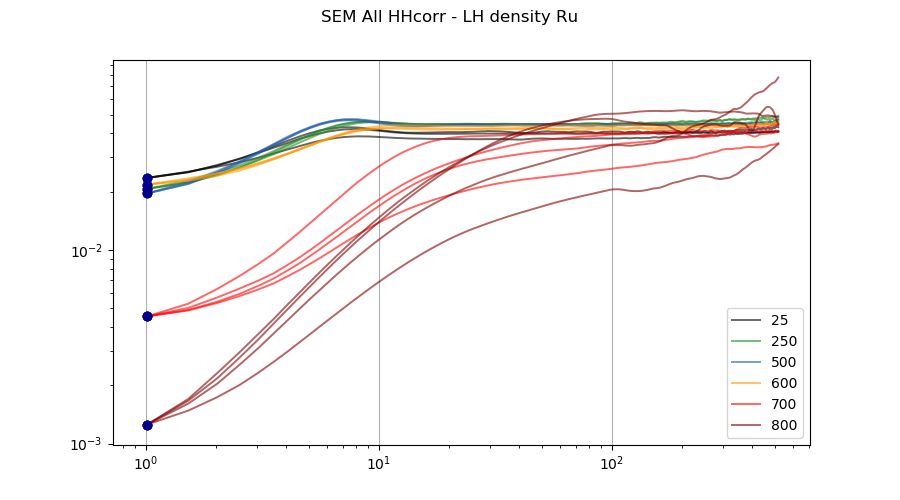

In [40]:
# *** If I want to see each single HHcorr function (interpolated but not averaged)
fig, ax = plt.subplots(figsize = (9,5))
temperatures = ['25','250','500','600','700','800']
colors = ['black','forestgreen', '#225ea8', '#ff9900', '#ff0000', '#800000']

density = 'LH'

for temp, color in zip(temperatures, colors):
    selection = df[df.temp==temp]
    selection = selection[selection.density==density]
    
    if len(selection)==0:
            print(f"Selection df with T={temp} and density={density} is empty")
            continue
            
    label = temp
    for idx, row in selection.iterrows():
        ax.loglog(
            x_new[density][ref_idx:],
            row.hhcorr_interp_offset[ref_idx:],
            c = color,
            alpha = 0.6,
            linewidth = 1.4,
            label = label
        )
        ax.scatter(x_new[density][ref_idx], row.hhcorr_interp_offset[ref_idx], c='darkblue', zorder=10)
        label = None
ax.legend()
titl = f"SEM All HHcorr - {density} density Ru"
fig.suptitle(titl)
ax.xaxis.grid() # vertical lines
figname = f"{titl}.png"
# fig.savefig(f'SEM_All HH-correlation functions in one plot - {density} density Ru.png', dpi=600)

# Plot Average HHcorr, without fit

<IPython.core.display.Javascript object>


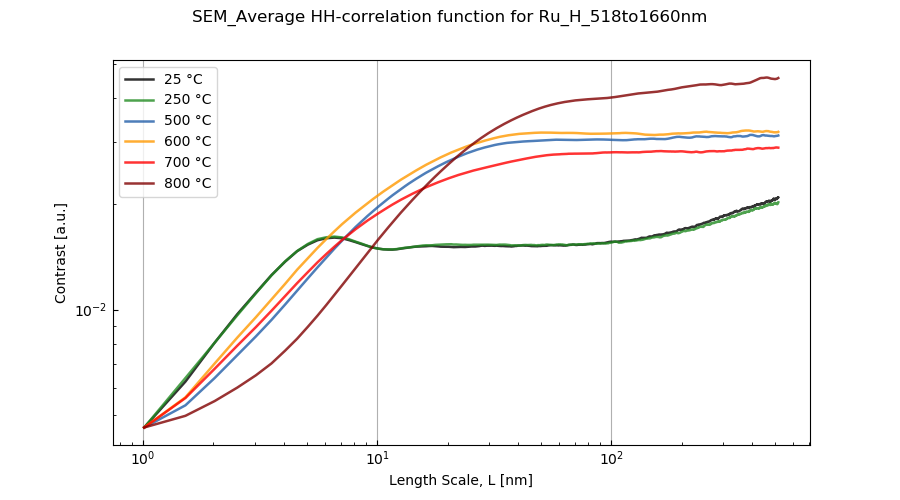

In [41]:
plt.style.use('default')
fig, ax = plt.subplots(figsize = (9,5))
temperatures = ['25','250','500','600','700','800']
colors = ['black', 'forestgreen','#225ea8', '#ff9900', '#ff0000', '#800000']

density = 'H'
for temp, color in zip(temperatures, colors):
    
    if len(adj_hhcorr[density][temp])==0:
        continue

    label = f"{temp} °C"
    ax.loglog(
        x_new[density][ref_idx:],
        adj_hhcorr[density][temp]['value'][ref_idx:],
        c = color,
        alpha = 0.8,
        linewidth = 1.8,
        label = label
    )

    label = None
ax.legend()
ax.tick_params(direction='in')
ax.tick_params(which = 'minor', direction = 'in')
ax.set(ylabel='Contrast [a.u.]')
ax.set(xlabel='Length Scale, L [nm]')

titl = f"SEM_Average HH-correlation function for Ru_{density}_{interval}"
fig.suptitle(titl)

figname = f"{titl}.svg"
# fig.savefig(f'{titl}', dpi=600)


ax.xaxis.grid() # vertical lines

# Fit the data

`[ ] TODO: Define a different cutoff`

In [28]:
def idx_from_x(x, array):
    # given an array, finds the index of the first element equal to the x given
    return np.argwhere(array>=x)[0][0]

In [ ]:
interval = {}
densities = ['L','H','LH']
temperatures = ['25','250']

for d in densities:
    interval [d] = {}
    for t in temperatures:
        interval[d][t]={}
        print(d,t)
        interval[d][t]['x0'] = int(idx_from_x( float(input('x0 (nm):')) , x_new[d] ))
        interval[d][t]['cutoff_idx'] = int(idx_from_x(float(input('cutoff length (nm):')),
                                                  x_new[d] ))
        
with open('Intervals_SEM_0.json', 'w') as f:
    json.dump(interval, f, indent=3)

# H: 2,5  2,4  3,9  2,15  3,10  5,19
# L: 2,4  2,4  2,5   2,5    2,6   4,14
# LH: 2,5  2,5  2,5   3,7   3,9   3,12

In [42]:
with open('Intervals_SEM_0.json', 'r') as f:
    interval = json.loads(f.read()) 

# new dataframe
temperatures = ['25','250','500','600','700','800']
# temperatures = ['25','250']
densities = ['L','H','LH']

Model = lambda x, a, alpha: a*x**(2*alpha)  

df_results = pd.DataFrame(columns= 
                   ['density',
                    'temp', 
                    'saturation',
                    'alpha',
                    'corrlen'])  
fit ={}
corrlen ={}
y_err={}
for dens in densities:
    fit[dens] = {}
    corrlen[dens]={}
    y_err[dens]={}
    for t in temperatures:
        corrlen[dens][t]={}
        y_err[dens][t]={}
        fit[dens][t]={}
        fit[dens][t]['density'] = dens
        fit[dens][t]['temperature'] = t
        
        if len(AvHHcorr[dens][t])==0:
            continue
            
        fit[dens][t]['limit'] = np.mean(AvHHcorr[dens][t]['value'][30:500]) #this was [30:500] 
        
#         y_err[dens][t] = (np.sqrt(AvHHcorr[dens][t]['value']))
#         y_err[dens][t] = np.arange(x0,200)**3


        x0 = interval[dens][t]['x0']
        cutoff_idx = interval[dens][t]['cutoff_idx']
        fit[dens][t]['results'], _ = curve_fit(
                                        Model, 
                                        x_new[dens][x0:cutoff_idx], 
                                        AvHHcorr[dens][t]['value'][x0:cutoff_idx],
                                        sigma = None
#                                         sigma = y_err[dens][t][x0:cutoff_idx]
#                                         bounds = (x0,cutoff_idx)
                                        )
        a =  fit[dens][t]['results'][0]
        alpha  =  fit[dens][t]['results'][1]

        corrlen[dens][t] = (1/a*(fit[dens][t]['limit']))**(1/(2*alpha))

# *** Create new dataframe for the calculation of CorrLen and Alpha on this data:
        df_results = df_results.append( 
                {'density': fit[dens][t]['density'],
                 'temp': fit[dens][t]['temperature'],  
                 'saturation': fit[dens][t]['limit'], 
                 'alpha': alpha,
                 'corrlen': corrlen[dens][t]
                },
                ignore_index=True)
pickle.dump(df_results, open( "SEM_AvHHcorr_interpolated.p", "wb" ) )
# df_results.to_excel(f"output_100-3000.xlsx")  # doctest: +SKIP

<IPython.core.display.Javascript object>


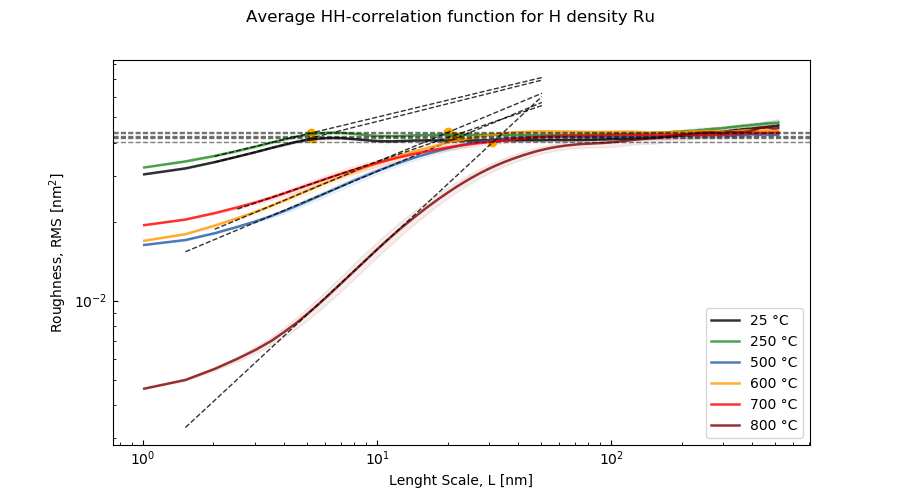

Text(0.5, 0.98, 'Average HH-correlation function for H density Ru')

In [43]:
# *** Plot everything in one graph:
plt.style.use('default')
fig, ax = plt.subplots(figsize = (9,5))
temperatures = ['25', '250','500', '600', '700', '800']
# temperatures = ['25', '250']

colors = ['black', 'forestgreen','#225ea8', '#ff9900', '#ff0000', '#800000']

for temp, color in zip(temperatures, colors):
    
    if len(AvHHcorr[density][temp])==0:
        continue
    
    density = 'H'
    
    label = f"{temp} °C"
    ax.loglog(
        x_new[density][1:],
        AvHHcorr[density][temp]['value'][1:],
        c = color,
        alpha = 0.8,
        linewidth = 1.8,
        label = label
    )
    ax.fill_between(
        x_new[density][1:],
        AvHHcorr[density][temp]['value_lower'][1:],
        AvHHcorr[density][temp]['value_upper'][1:],
        color = color,
        alpha = 0.075
    )
    
    ax.loglog(
        x_new[density][interval[dens][temp]['x0']:100], 
        Model(x_new[density][interval[dens][temp]['x0']:100],*fit[density][temp]['results']), 
        linewidth = 1, 
        linestyle='dashed', 
        alpha = 0.8, 
        c ='k')
    ax.scatter(corrlen[density][temp], fit[density][temp]['limit'], marker='o', color='orange')
    ax.axhline(fit[density][temp]['limit'], linestyle="dashed",linewidth = 1, color = 'black', zorder =5, alpha =0.5)
    

    label = None

ax.legend()
ax.tick_params(direction='in')
ax.tick_params(which = 'minor', direction = 'in')
ax.set(ylabel='Roughness, RMS [nm$^2$]')
ax.set(xlabel='Lenght Scale, L [nm]')
titl = f"Average HH-correlation function for {density} density Ru"
fig.suptitle(titl)

# figname = f"{titl}.png"
# fig.savefig(f'SEM_Average HH function - Ru_{density}_asDepOnly_2ndcorr.png', dpi=600)

<IPython.core.display.Javascript object>


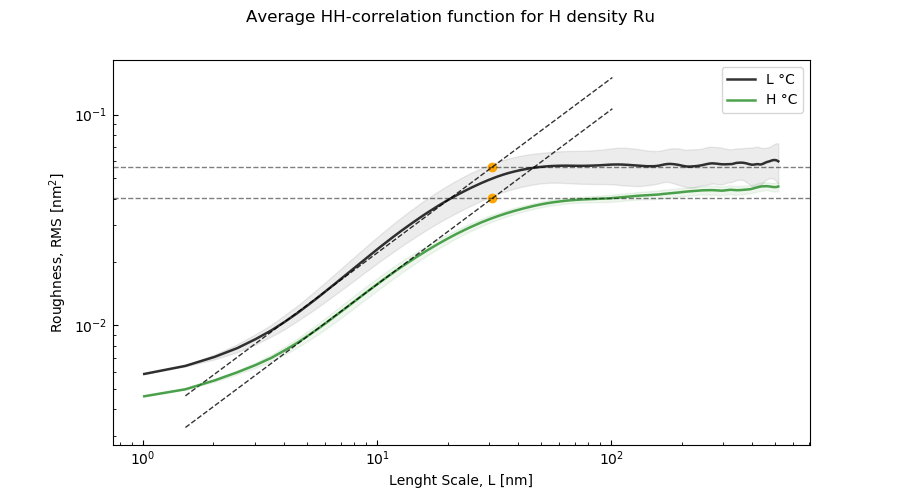

In [44]:
# *** Plot everything in one graph:
plt.style.use('default')
fig, ax = plt.subplots(figsize = (9,5))
# temperatures = ['25', '250','500', '600', '700', '800']
temperatures = ['25']
densities = ['L','H']

colors = ['black', 'forestgreen','#225ea8', '#ff9900', '#ff0000', '#800000']
# styles = ['--','-.']

for density, color in zip(densities, colors):
#     for temp, style in zip(temperatures, styles):

    
        if len(AvHHcorr[density][temp])==0:
            continue

    #     density = 'L'

        label = f"{density} °C"
        
        ax.loglog(
            x_new[density][1:],
            AvHHcorr[density][temp]['value'][1:],
#             linestyle=style,
            c = color,
            alpha = 0.8,
            linewidth = 1.8,
            label = label
        )
        ax.fill_between(
            x_new[density][1:],
            AvHHcorr[density][temp]['value_lower'][1:],
            AvHHcorr[density][temp]['value_upper'][1:],
#             linestyle=style,
            color = color,
            alpha = 0.075
        )

        ax.loglog(
            x_new[density][interval[dens][temp]['x0']:200], 
            Model(x_new[density][interval[dens][temp]['x0']:200],*fit[density][temp]['results']), 
            linewidth = 1, 
            linestyle='dashed', 
            alpha = 0.8, 
            c ='k')
        ax.scatter(corrlen[density][temp], fit[density][temp]['limit'], marker='o', color='orange')
        ax.axhline(fit[density][temp]['limit'], linestyle="dashed",linewidth = 1, color = 'black', zorder =5, alpha =0.5)


        label = None
ax.legend()
ax.tick_params(direction='in')
ax.tick_params(which = 'minor', direction = 'in')
ax.set(ylabel='Roughness, RMS [nm$^2$]')
ax.set(xlabel='Lenght Scale, L [nm]')
titl = f"Average HH-correlation function for {density} density Ru"
fig.suptitle(titl)

figname = f"{titl}.png"
fig.savefig(f'SEM_Average HH function - Ru_{density}_asDepOnly_2ndcorr.png', dpi=600)